In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import seaborn as sns

In [6]:
train_dataset = pd.read_csv('./data/sign_mnist_train/sign_mnist_train.csv')
test_dataset = pd.read_csv('./data/sign_mnist_test/sign_mnist_test.csv')

In [7]:
#shuffling the dataset

train_dataset = train_dataset.sample(frac = 1.0).reset_index(drop = True)
test_dataset = test_dataset.sample(frac = 1.0).reset_index(drop = True)

In [8]:
# Peeking the dataset
train_dataset.iloc[:4,:10]

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9
0,8,162,164,165,166,166,166,166,165,165
1,15,108,115,123,128,134,137,140,143,146
2,12,105,116,124,128,132,138,143,147,151
3,16,64,68,73,77,80,85,95,102,109


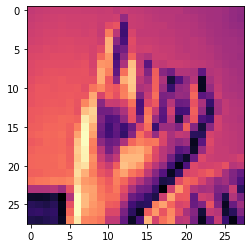

In [9]:
def make_image(arr , label=True):
    arr = np.array(arr)
    start_idx = 1 if label else 0
    return arr[start_idx:].reshape(28,28).astype(float)

image = make_image(train_dataset.iloc[0])
plt.imshow(image, cmap = 'magma')
plt.show()

In [11]:
train_data_og = train_dataset.copy()

v_index = int(train_dataset.shape[0]*0.1)

validation_data = train_data_og.iloc[:v_index]
train_data = train_data_og.iloc[v_index:]

#validation_data.shape

Y_train = train_data['label']
Y_test = test_dataset['label']
Y_validation = validation_data['label']

X_train = train_data.drop('label',axis = 1).values.reshape(train_data.shape[0], 28, 28, 1)
X_test = test_dataset.drop('label',axis = 1).values.reshape(test_dataset.shape[0], 28, 28, 1)
X_validation = validation_data.drop('label',axis = 1).values.reshape(validation_data.shape[0], 28, 28, 1)

In [13]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=10,
                                                            zoom_range=0.10,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            horizontal_flip=False,
                                                            fill_mode="nearest")

X_train_flow = generator.flow(X_train, Y_train, batch_size=32)
X_val_flow = generator.flow(X_validation, Y_validation, batch_size=32)

In [14]:
model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=512, kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Flatten(),
                    
                    Dense(units=1024, activation="relu"),                 
                    Dense(units=256, activation="relu"),
                    Dropout(0.5),
                    Dense(units=25, activation="softmax")
])

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 128)       36992     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 512)         590336    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(X_train_flow, 
                    validation_data=X_val_flow, 
                    epochs=100,
                    callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True), 
                        
                            learning_rate_reduction
                    ])

Epoch 1/100
773/773 [==============================] - 36s 46ms/step - loss: 1.7482 - accuracy: 0.4351 - val_loss: 0.3744 - val_accuracy: 0.8718
Epoch 2/100
773/773 [==============================] - 35s 45ms/step - loss: 0.3081 - accuracy: 0.8930 - val_loss: 0.1923 - val_accuracy: 0.9301
Epoch 3/100
773/773 [==============================] - 35s 45ms/step - loss: 0.1215 - accuracy: 0.9608 - val_loss: 0.0575 - val_accuracy: 0.9789
Epoch 4/100
773/773 [==============================] - 35s 45ms/step - loss: 0.0710 - accuracy: 0.9780 - val_loss: 0.0384 - val_accuracy: 0.9898
Epoch 5/100
773/773 [==============================] - 35s 45ms/step - loss: 0.0541 - accuracy: 0.9822 - val_loss: 0.0282 - val_accuracy: 0.9913
Epoch 6/100
773/773 [==============================] - 35s 45ms/step - loss: 0.0504 - accuracy: 0.9843 - val_loss: 0.0157 - val_accuracy: 0.9938
Epoch 7/100
773/773 [==============================] - 35s 45ms/step - loss: 0.0408 - accuracy: 0.9877 - val_loss: 0.0078 - val_ac

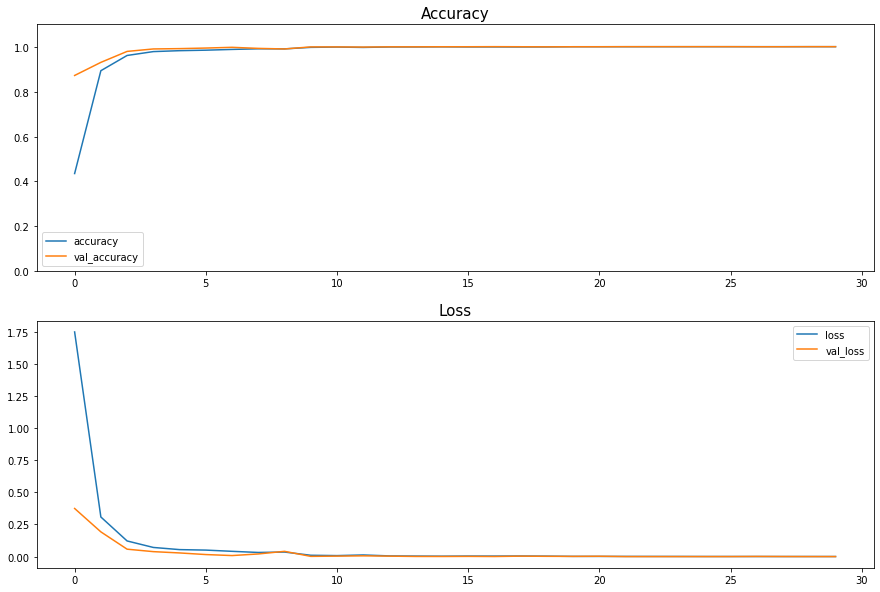

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [35]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

accuracy_score(Y_test,pred)

0.9976296709425544

In [1]:
import cv2

img_array = cv2.imread('./test.jpg', cv2.IMREAD_GRAYSCALE)
print(img_array)

[[ 94 110 126 132 131 133 135 136 139 140 139 133 141 135 140 136 138 135
  131 130 131 131 131 131 131 130 129 128]
 [ 60  72  91 112 126 131 132 132 130 135 139 133 136 131 134 128 129 129
  130 131 132 131 130 129 132 131 130 130]
 [126  93  62  61  83 106 120 125 132 125 130 133 135 129 131 129 128 128
  128 127 126 127 128 128 129 128 128 127]
 [140 144 136 107  70  53  67  90 120 115 121 122 121 123 124 124 124 124
  123 122 121 123 123 123 122 122 121 121]
 [148 142 138 138 137 121  86  55  53  81 115 122 117 120 117 119 115 117
  118 118 120 121 119 115 118 117 117 116]
 [142 142 141 138 140 142 136 127  98  66  49  64  94 116 110 121 116 117
  116 112 112 115 115 113 115 114 113 112]
 [157 153 147 141 139 139 138 137 138 123 129 156 166 138  91  99 105 110
  111 107 104 107 110 110 108 107 106 105]
 [172 164 157 154 150 143 139 140 132 137 144 153 153 124  59  51  77  91
  104 106 104 103 103 101 100  99  98  97]
 [184 175 182 184 162 157 152 146 140 130 131 139 124 114 117 10